In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.table import Table
import pandas as pd
import os
import sys
import glob
from astropy.coordinates import SkyCoord
from astropy import units as u
# from sklearn.neighbors import KDTree

%matplotlib inline
sb.set(style="ticks", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

def MAD(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def mask_ratio(x, y, n=3.):
    ratio = x / y
    ratio_MAD = MAD(ratio)
    mask = (ratio > np.median(ratio) - n * ratio_MAD) & \
           (ratio < np.median(ratio) + n * ratio_MAD)
    return mask

def mask_diff(x, y, n=3.):
    diff = x - y
    diff_MAD = MAD(diff)
    mask = (diff > np.median(diff) - n * diff_MAD) & \
           (diff < np.median(diff) + n * diff_MAD)
    return mask

In [3]:
field = 'Blind15A_25'
EXP_TIME = 86

In [4]:
ccds_file = '%s/INFO/ccds.txt' % (mainpath)
ccds = np.loadtxt(ccds_file, comments = '#', dtype = str)

epochs_g_file = '%s/INFO/%s/%s_epochs_%s.txt' % (mainpath, field, field, 'r')
epochs_g = np.loadtxt(epochs_g_file, comments = '#', dtype = str)
print epochs_g

[['01' '57070.0717088']
 ['24' '57077.0421334']
 ['27' '57080.0467181']
 ['31' '57095.1162608']
 ['33' '57089.2280307']]


In [16]:
cata_ccds = {}
PS_good_ccds = {}
PS_ccds = {}
info = []
for ccd in ccds:
    print '\r %s' % ccd,
    path = '%s/catalogues/%s/%s/%s_%s_%s_image_crblaster_thresh1.0_minarea1_backsize64_zp.dat'\
    % (mainpath, field, ccd, field, ccd, epochs_g[0,0])
    if not os.path.exists(path):
        print 'No catalog for this ccd...'  
        continue
    cata = Table.read(path, format='ascii').to_pandas()
    cata_ccds[ccd] = cata
    
    PS1_path = '%s/PanSTARRS/%s_PS1_%s.vot' % (mainpath, field, ccd)
    if not os.path.exists(PS1_path):
        print 'No catalog for this ccd...'  
        continue
    PS1_data = Table.read(PS1_path).to_pandas()
    PS_ccds[ccd] = PS1_data.query('rMeanKronMag > 0')
    PS1_data_good = PS1_data.query('rMeanKronMag > 16 and rMeanKronMag < 21')
    PS_good_ccds[ccd] = PS1_data_good

 S7 No catalog for this ccd...
 S31


CCD: N1
Number of matches wihitn 2 arcsec: 408
PS       : ZP: -25.390871 +- 0.046739
Bootstrap: ZP: -25.390871 +- 0.014885


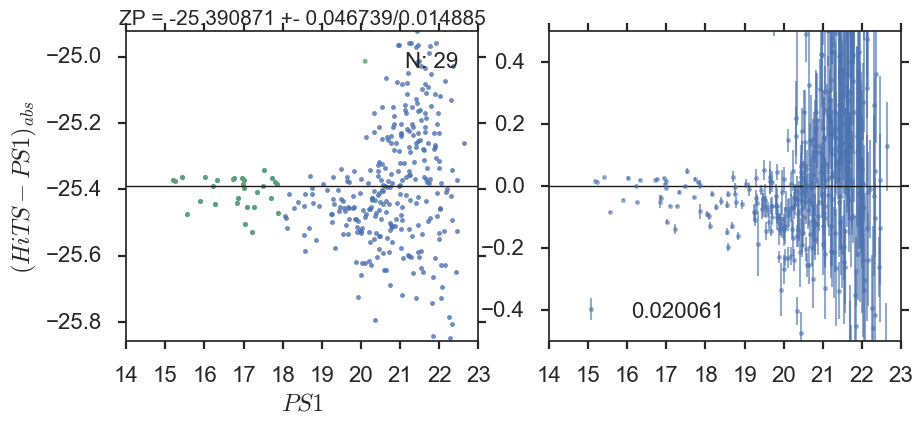

CCD: N2
Number of matches wihitn 2 arcsec: 466
PS       : ZP: -25.410901 +- 0.057940
Bootstrap: ZP: -25.411300 +- 0.008969


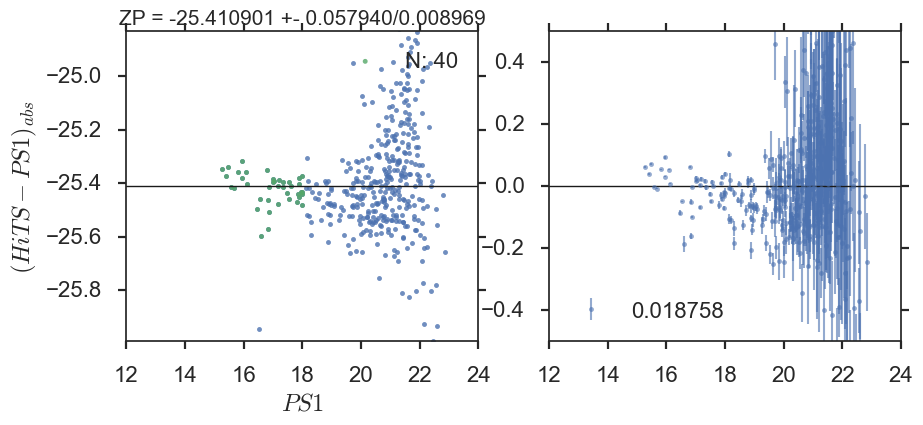

CCD: N3
Number of matches wihitn 2 arcsec: 564
PS       : ZP: -25.392485 +- 0.077982
Bootstrap: ZP: -25.389905 +- 0.015281


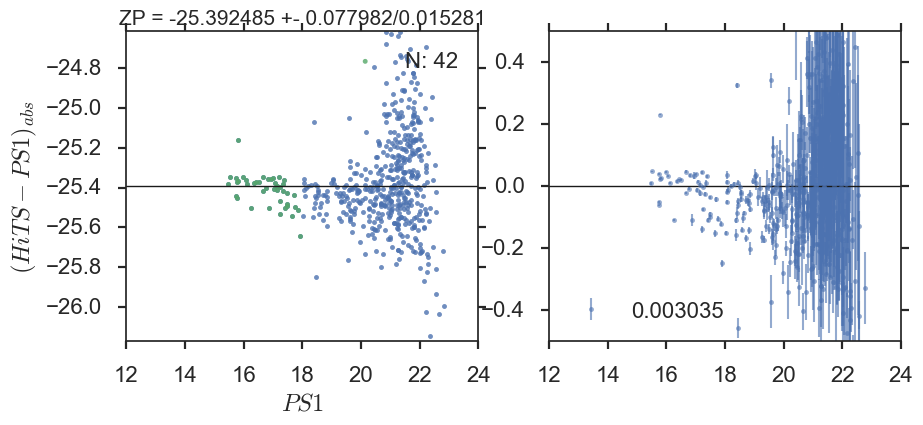

CCD: N4
Number of matches wihitn 2 arcsec: 527
PS       : ZP: -25.375409 +- 0.031109
Bootstrap: ZP: -25.375409 +- 0.005238


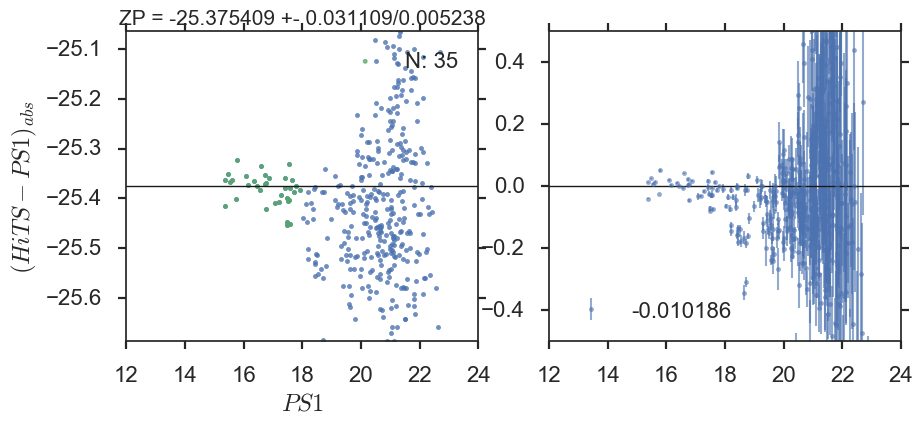

CCD: N5
Number of matches wihitn 2 arcsec: 539
PS       : ZP: -25.396910 +- 0.057273
Bootstrap: ZP: -25.396910 +- 0.012331


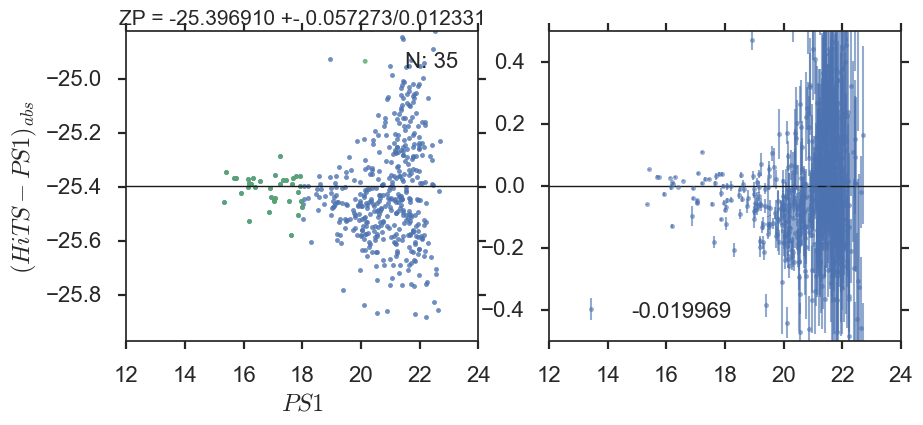

CCD: N6
Number of matches wihitn 2 arcsec: 465
PS       : ZP: -25.398538 +- 0.051247
Bootstrap: ZP: -25.400091 +- 0.016177


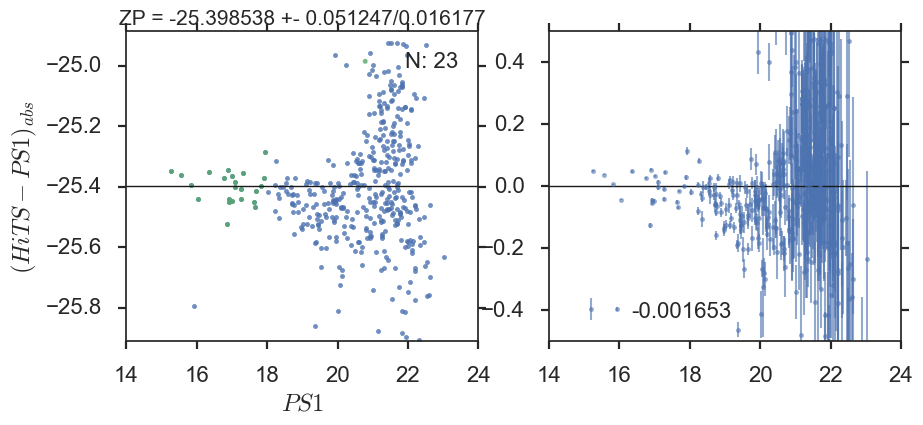

CCD: N7
Number of matches wihitn 2 arcsec: 572
PS       : ZP: -25.392311 +- 0.047267
Bootstrap: ZP: -25.382383 +- 0.010437


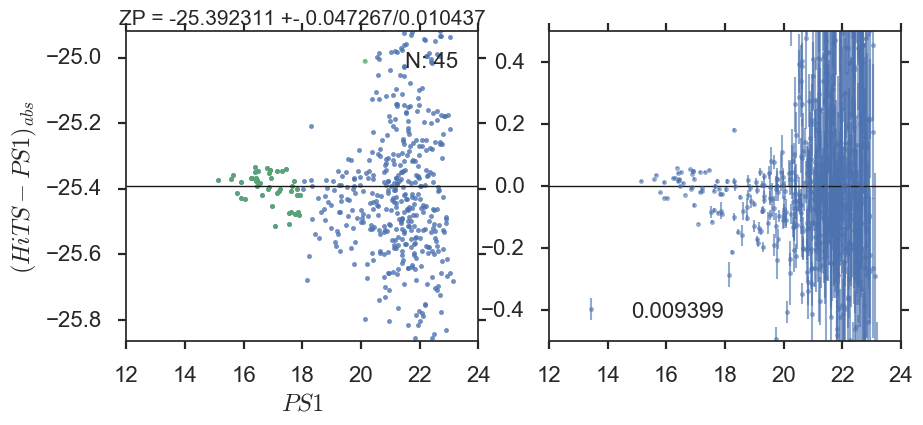

CCD: N8
Number of matches wihitn 2 arcsec: 396
PS       : ZP: -25.404643 +- 0.050011
Bootstrap: ZP: -25.404643 +- 0.013931


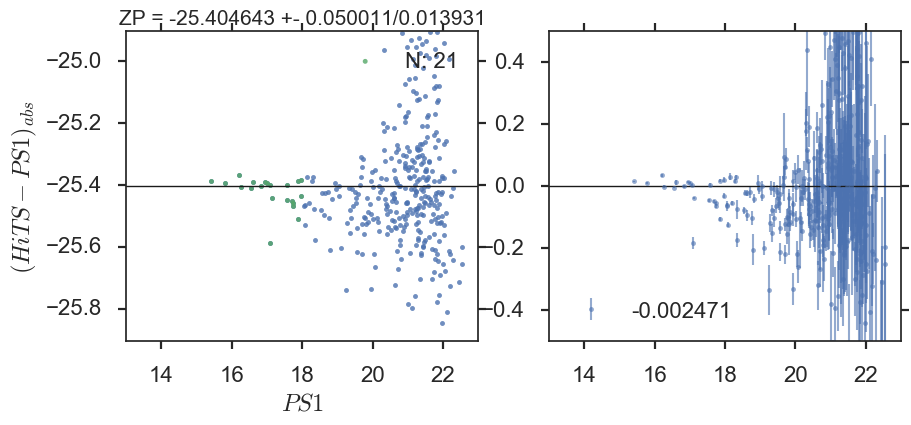

CCD: N9
Number of matches wihitn 2 arcsec: 653
PS       : ZP: -25.373813 +- 0.080769
Bootstrap: ZP: -25.373813 +- 0.009317


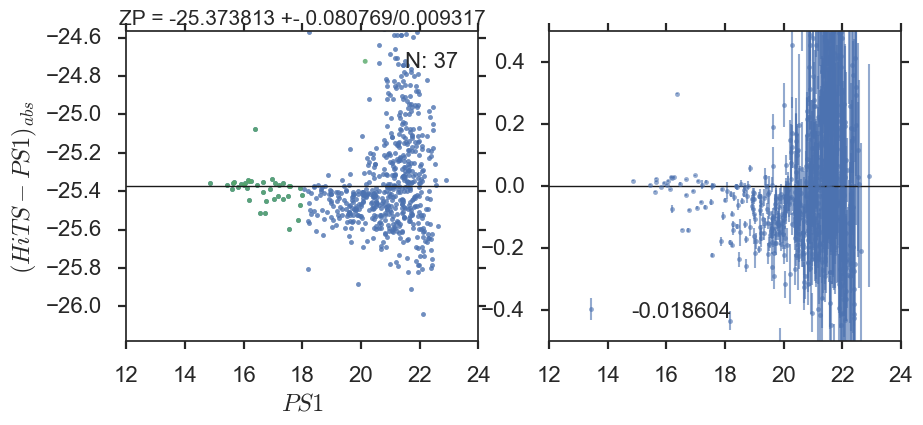

CCD: N10
Number of matches wihitn 2 arcsec: 601
PS       : ZP: -25.387327 +- 0.061056
Bootstrap: ZP: -25.387327 +- 0.014033


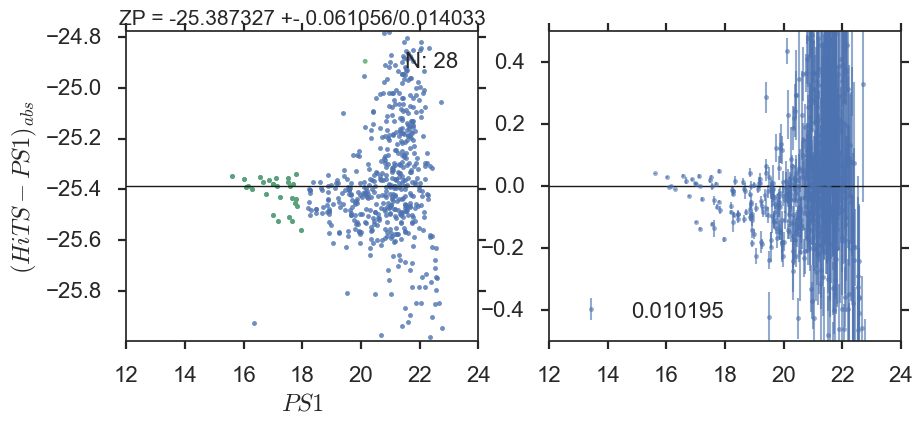

In [30]:
zp_ps_ccds_dict = {}
zp_ps_ccds = []
dif_HiTS_PS_dict = {}
dif_HiTS_PS = []
e_dif_HiTS_PS_dict = {}
e_dif_HiTS_PS = []
for k,ccd in enumerate(ccds):
    
    print 'CCD:',  ccd
    if ccd == 'S7': continue
    
    ##################################################################
    # RaDec sky match between HiTS and PS1
    ##################################################################
    PS1_coord = SkyCoord(ra=PS_ccds[ccd]['raMean'].values, 
                         dec=PS_ccds[ccd]['decMean'].values,
                         frame='icrs', unit=u.degree)
    
    HiTS_coord = SkyCoord(ra=cata_ccds[ccd]['RA'].values, 
                          dec=cata_ccds[ccd]['DEC'].values, 
                          frame='icrs', unit=u.degree)
    idx, d2d, d3d = HiTS_coord.match_to_catalog_3d(PS1_coord)
    mask_less2 = (d2d.arcsec < 1.1)
    print 'Number of matches wihitn 2 arcsec:', len(idx[mask_less2])
    
    match_PS1  = PS_ccds[ccd].iloc[idx[mask_less2]]
    match_HiTS = cata_ccds[ccd].iloc[mask_less2]
    
    ##################################################################
    # Option 2
    ##################################################################
    
    flux_auto = match_HiTS.FLUX_AUTO.values
    fluxerr_auto = match_HiTS.FLUXERR_AUTO_COR.values
    
    m_ps1 = -2.5*np.log10(flux_auto) + 2.5*np.log10(EXP_TIME)
    
    phot_dif = m_ps1 - match_PS1.rMeanKronMag.values
    mask_d   = (mask_diff(match_PS1.rMeanKronMag.values, m_ps1, n=3)) &\
              (match_PS1.rMeanKronMag.values < 18)
    zp_ps1   = np.median(phot_dif[mask_d]) # ZP from difference after mask
    e_zp_ps1 = np.std(phot_dif[mask_d])    # error of ZP from std of difference
    
    # bootstrap over difference to improve ZP and e_ZP
    boostrap = np.zeros(100)
    for k in range(100):
        boostrap[k] = np.median(np.random.choice(phot_dif[mask_d], 
                                size=len(phot_dif[mask_d]), replace=True))
    zp_ps1_boost   = np.median(boostrap)
    e_zp_ps1_boost = np.std(boostrap)

    print 'PS       : ZP: %f +- %f'% (zp_ps1, e_zp_ps1)
    print 'Bootstrap: ZP: %f +- %f'% (zp_ps1_boost, e_zp_ps1_boost)
    
    mag_HiTS_ps1corr = m_ps1 - zp_ps1
    
    dif_HiTS_PS_dict[ccd] = mag_HiTS_ps1corr - match_PS1.rMeanKronMag.values
    e_dif_HiTS_PS_dict[ccd] = np.sqrt((2.5*fluxerr_auto/(flux_auto*np.log(10)))**2 +
                                 match_PS1.rMeanKronMagErr.values**2)
    
    out_path = '%s/INFO/%s/%s_%s_%s_dif.npy' % (mainpath, field, field, ccd, epochs_g[0,0])
    #print out_path
    #print np.array([dif_HiTS_PS_dict[ccd], e_dif_HiTS_PS_dict[ccd]]).T
    np.save(out_path, np.array([match_PS1.rMeanKronMag.values,
                                dif_HiTS_PS_dict[ccd], e_dif_HiTS_PS_dict[ccd]]).T)
    
    zp_ps_ccds_dict[ccd] = [zp_ps1, e_zp_ps1, e_zp_ps1_boost]
    zp_ps_ccds.append([zp_ps1, e_zp_ps1, e_zp_ps1_boost])
    
    fig, ax = plt.subplots(1,2, sharex=True, figsize=(10,4))
    
    ax[0].axhline(zp_ps1, c='k', ls='-', lw=1)
    ax[0].axhline(zp_ps1 + 3.*np.std(phot_dif), c='k', ls='--', lw=1)
    ax[0].axhline(zp_ps1 - 3.*np.std(phot_dif), c='k', ls='--', lw=1)
    ax[0].scatter(match_PS1.rMeanKronMag.values, phot_dif, marker='.', 
                alpha=.8, lw=0, s=50, c='b')
    ax[0].scatter(match_PS1.rMeanKronMag.values[mask_d], 
                phot_dif[mask_d], marker='.',alpha=.8, 
                lw=0, s=50, c='g', label='N: %i' % (len(phot_dif[mask_d])))
    ax[0].legend(loc='best')
    ax[0].set_ylabel(r'$(HiTS - PS1)_{abs}$')
    ax[0].set_xlabel(r'$PS1$')
    ax[0].set_title('ZP = %f +- %f/%f' % (zp_ps1, e_zp_ps1, e_zp_ps1_boost),
                   fontsize=15)
    #ax[0].set_xlim(14,22)
    ax[0].set_ylim(zp_ps1 - 10* e_zp_ps1, zp_ps1 + 10* e_zp_ps1)
    
    ax[1].axhline(0, c='k', ls='-', lw=1)
    ax[1].errorbar(match_PS1.rMeanKronMag.values,
                   dif_HiTS_PS_dict[ccd],
                   yerr=e_dif_HiTS_PS_dict[ccd], 
                   alpha=.6, lw=1.5, fmt='.', ms=7, c='b',
                   label='%f'%
                (np.median(mag_HiTS_ps1corr - match_PS1.rMeanKronMag.values)))
    ax[1].legend(loc='lower left')
    ax[1].set_ylim(-.5,.5)
    plt.show()
    
    if ccd=='N10': break
    
zp_ps_ccds = np.array(zp_ps_ccds)

0.00688236798692


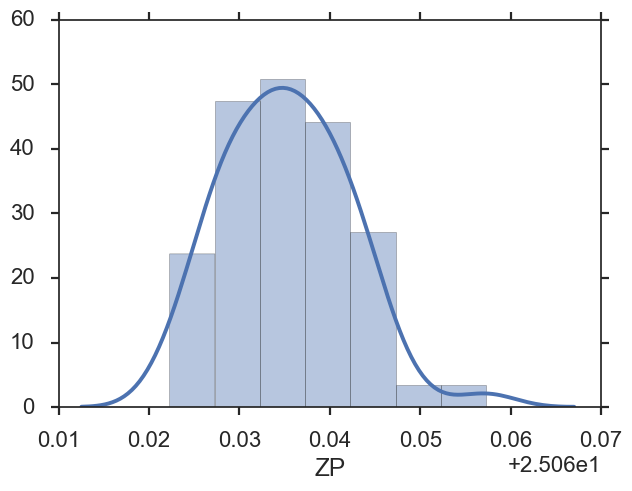

In [41]:
print np.std(zp_ps_ccds[:,0])
plt.figure(figsize=(7,5))
sb.distplot(zp_ps_ccds[:,0])
plt.xlabel('ZP')
plt.show()

In [ ]:
print np.std(zp_ps_ccds[:,0])
plt.figure(figsize=(7,5))
sb.distplot(dif_HiTS_PS_dict['N1'])
plt.xlabel('ZP')
plt.show()